In [78]:

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import mne.channels
import copy
from mne_connectivity import spectral_connectivity_epochs

In [20]:
# Cargamostodo y asignamos que show, ruta, tiempos, canales,
root_dir = r"C:\Users\rayom\ds005307"
tmin, tmax = -0.5, 1.5
baseline = (-0.5, -0.0)
eeg_channels = ['Cz', 'Fz', 'Pz', 'C3', 'C4', 'T7', 'T8', 'P3', 'P4', 'O1', 'O2', 'A1', 'A2', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8']
n2_time = 0.250
p2_time = 0.400

# Frecuencia de muestreo estándar que esta en el data set por defecto
target_sfreq = 1000.0


# Función de Procesasmiento

def process_subject_run(subject_dir, run_id):


    subject_id = os.path.basename(subject_dir)

    # Encontrar los archivos de cada sujeto
    vhdr_filename = f'{subject_id}_task-pain_run-{run_id}_eeg.vhdr'
    events_filename = f'{subject_id}_task-pain_run-{run_id}_events.tsv'

    vhdr_path = os.path.join(subject_dir, 'eeg', vhdr_filename)
    events_path = os.path.join(subject_dir, 'eeg', events_filename)

    if not os.path.exists(vhdr_path) or not os.path.exists(events_path):
         return None

    # CARGAR Y PREPROCESAR DATOS
    try:
        raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)
    except Exception as read_err:
         print(f" DEBUG: Error CRÍTICO de MNE al cargar RAW para {subject_id}.")
         print(f"    ERROR DETALLADO: {read_err}")
         return None

    # Remuestreo a la frecuencia estándar
    if raw.info['sfreq'] != target_sfreq:
        print(f" {subject_id}: Remuestreo de {raw.info['sfreq']:.1f} Hz a {target_sfreq:.1f} Hz.")
        raw.resample(sfreq=target_sfreq)

    # Referencia y Montaje
    ref_channels = ['A1', 'A2']
    available_refs = [ch for ch in ref_channels if ch in raw.ch_names]
    if len(available_refs) == 2:
        raw.set_eeg_reference(ref_channels=available_refs, projection=False, verbose=False)
    else:
        raw.set_eeg_reference(ref_channels='average', projection=False, verbose=False)

    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')

    global eeg_channels
    final_eeg_channels = [ch for ch in eeg_channels if ch in raw.ch_names]
    if not final_eeg_channels:
         return None

    raw.pick_channels(final_eeg_channels, ordered=True)

    # Extraer eventos y Metadatos del archivo tvs
    events_tsv = pd.read_csv(events_path, sep='\t')
    pain_events_tsv = events_tsv[events_tsv['trial_type'] == 'pain'].copy()

    if pain_events_tsv.empty:
        return None

    events_array = pain_events_tsv[['sample']].values.astype(int)
    events_array = np.c_[events_array, np.zeros_like(events_array), np.ones_like(events_array)]

    # Crear metadatos DUMMY (usando el dataframe de eventos completo) ???????????????????????????????????????????????????????????????
    metadata = pain_events_tsv.copy()
    if 'LaserPower' not in metadata.columns:
         metadata['LaserPower'] = 1.0
    if 'PainRating' not in metadata.columns:
         metadata['PainRating'] = 5

    # Generamos las Épocas
    epochs = mne.Epochs(
        raw,
        events_array,
        event_id={'pain_stim': 1},
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        preload=True,
        reject_by_annotation=False,
        verbose=False
    )

    # Aqui Sincronizamos los metadatos con las épocas conservadas
    if len(epochs.drop_log) > 0 and any(len(d) > 0 for d in epochs.drop_log):
        metadata_filtered = metadata.iloc[epochs.selection].reset_index(drop=True)
    else:
        # Si no se descartó nada, usamos el metadata completo
        metadata_filtered = metadata.reset_index(drop=True)

    epochs.metadata = metadata_filtered

    if len(epochs) == 0:
         print(f" {subject_id}: Todas las {len(events_array)} épocas fueron rechazadas.")
         return None

    print(f" Procesado: {subject_id}, Run 01. Épocas: {len(epochs)}")
    return epochs

In [21]:

# Procesamiento de los 3 sujetos
print("\nIniciando el procesamiento de datos...")

subject_ids_to_process = ['sub-esg01', 'sub-esg02', 'sub-esg03']
all_epochs = []

for subject_id in subject_ids_to_process:
    subject_dir = os.path.join(root_dir, subject_id)
    if os.path.exists(subject_dir):
        epochs = process_subject_run(subject_dir, '01')
        if epochs is not None:
            all_epochs.append(epochs)
    else:
        print(f" DIRECTORIO NO ENCONTRADO: {subject_dir}")


print(f"\nNúmero de sujetos procesados exitosamente (all_epochs): {len(all_epochs)}")

if not all_epochs:
    print("\n ERROR FATAL: 0 sujetos procesados. El análisis no puede continuar.")
    exit()

# Concatenar épocas de todos los sujetos (Esta parte hubo errores grandísimos portodo el tema con las frecuencias y voltajes distintos
grand_epochs = mne.concatenate_epochs(all_epochs, on_mismatch='ignore')
print(f"\nTotal de épocas concatenadas (trials): {len(grand_epochs)}")


Iniciando el procesamiento de datos...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Adding metadata with 7 columns
✅ Procesado: sub-esg01, Run 01. Épocas: 36
⚠️ sub-esg02: Remuestreo de 10000.0 Hz a 1000.0 Hz.
Finding events on: STI 014
36 events found on stim channel STI 014
Event IDs: [5]
Finding events on: STI 014
36 events found on stim channel STI 014
Event IDs: [5]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Adding metadata with 7 columns
✅ Procesado: sub-esg02, Run 01. Épocas: 1
⚠️ sub-esg03: Remuestreo de 10000.0 Hz a 1000.0 Hz.
Finding events on: STI 014
36 events found on stim channel STI 014
Event IDs: [5]
Finding events on: STI 014
36 events found on stim channel STI 014
Event IDs: [5]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Adding metadata with 7 columns
✅ Procesado: sub-esg03, Run 01. Épocas: 3

Número de sujetos procesados exitosamente (all_epochs): 3
Adding me

C:\Users\rayom\AppData\Local\Temp\ipykernel_14972\1404454722.py:26: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  grand_epochs = mne.concatenate_epochs(all_epochs, on_mismatch='ignore')


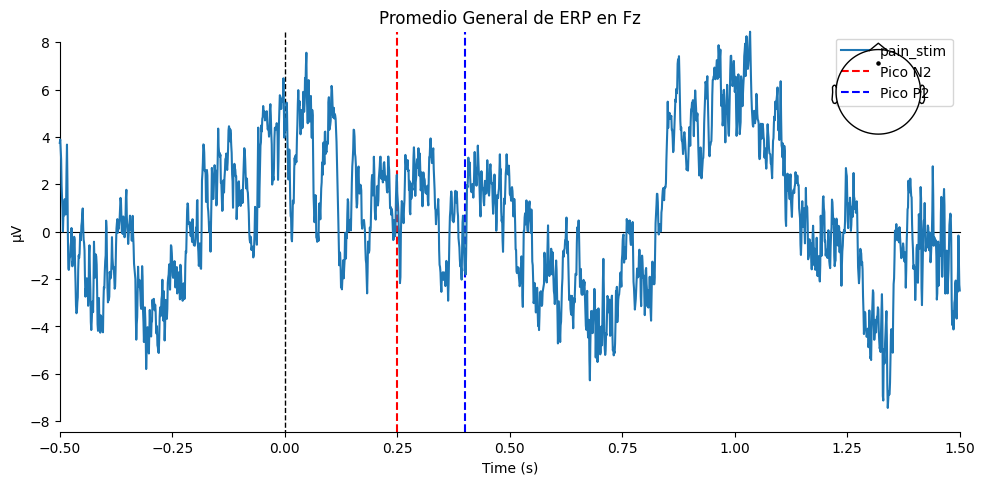

In [94]:

# Visualizamos las figuras y resultados

# Calculamos el promedio general
grand_average_erp = grand_epochs.average()

# Canal de interés Fz
channel_of_interest = 'Fz'
if channel_of_interest not in grand_average_erp.ch_names:
     # Si Fz no existe (aunque es raro), usa el primer canal disponible
     channel_of_interest = grand_average_erp.ch_names[0]


# Gráfico del ERP
fig_erp, ax_erp = plt.subplots(1, 1, figsize=(12, 8))

mne.viz.plot_compare_evokeds(
    [grand_average_erp],
    picks=[channel_of_interest],
    axes=ax_erp,
    ci=True,
    show=False,
    title=f'Promedio General de ERP en {channel_of_interest}'
)
ax_erp.axvline(n2_time, color='r', linestyle='--', label='Pico N2')
ax_erp.axvline(p2_time, color='b', linestyle='--', label='Pico P2')
ax_erp.legend()

fig_erp.subplots_adjust(right=0.9, top=0.75, bottom=0.25, left=0.15)

plt.savefig('Grand_Average_ERP.png')


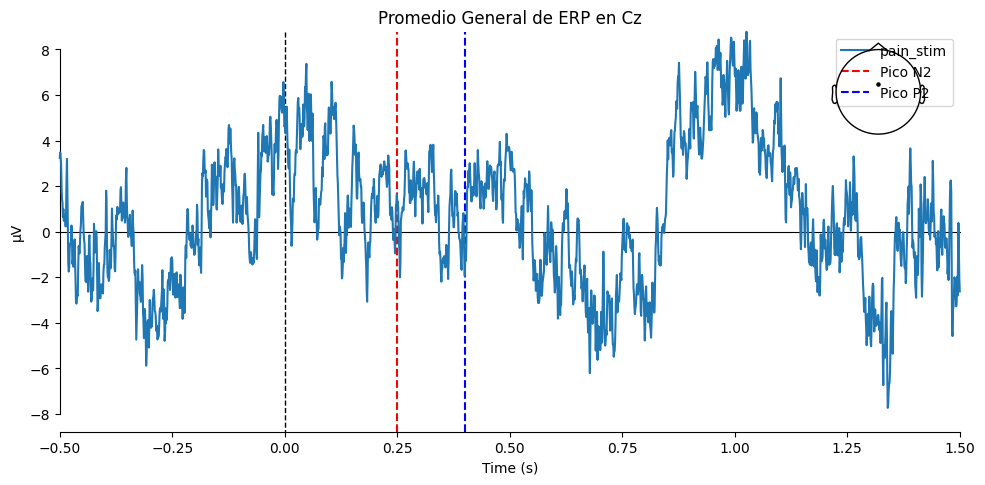

In [99]:
# Calculamos el promedio general
grand_average_erp = grand_epochs.average()

channel_of_interest = 'Cz'
if channel_of_interest not in grand_average_erp.ch_names:
     # Si Cz no existe, usa el primer canal disponible
     channel_of_interest = grand_average_erp.ch_names[0]


# Gráfico del ERP
fig_erp, ax_erp = plt.subplots(1, 1, figsize=(12, 8))

mne.viz.plot_compare_evokeds(
    [grand_average_erp],
    picks=[channel_of_interest],
    axes=ax_erp,
    ci=True,
    show=False,
    title=f'Promedio General de ERP en {channel_of_interest}'
)
# n2_time y p2_time deben estar definidos previamente
ax_erp.axvline(n2_time, color='r', linestyle='--', label='Pico N2')
ax_erp.axvline(p2_time, color='b', linestyle='--', label='Pico P2')
ax_erp.legend()

fig_erp.subplots_adjust(right=0.9, top=0.75, bottom=0.25, left=0.15)

# Guardamos la figura con un nombre diferente para distinguirla de Fz
plt.savefig('Grand_Average_ERP_Cz.png')


--- Amplitudes N2/P2 vs. Potencia del Láser (Usando datos DUMMY) ---
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Resultados de Amplitud N2 por Potencia de Láser guardados en N2_Amplitud_vs_LaserPower.csv


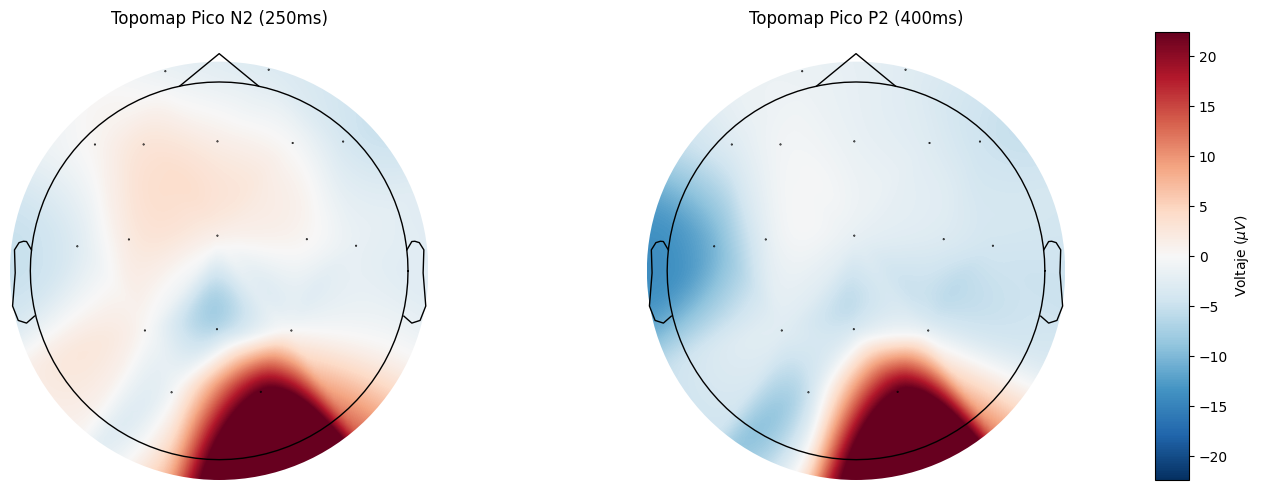

In [29]:

fig_topo, axes_topo = plt.subplots(1, 3, figsize=(14, 5),
                                   gridspec_kw={'width_ratios': [1, 1, 0.05]})

cbar_ax = axes_topo[2]

# Topomap del Pico N2 (~250ms)
grand_average_erp.plot_topomap(
    times=n2_time,
    axes=axes_topo[0],
    show=False,
    ch_type='eeg',
    contours=0,
    colorbar=False # Desactivamos colorbar individual
)
im1 = axes_topo[0].images[0]
axes_topo[0].set_title(f'Topomap Pico N2 ({int(n2_time*1000)}ms)')

# Topomap del Pico P2 (~400ms)
grand_average_erp.plot_topomap(
    times=p2_time,
    axes=axes_topo[1],
    show=False,
    ch_type='eeg',
    contours=0,
    colorbar=False
)
axes_topo[1].set_title(f'Topomap Pico P2 ({int(p2_time*1000)}ms)')

cbar = fig_topo.colorbar(im1, cax=cbar_ax)
cbar.set_label('Voltaje ($\mu V$)')

fig_topo.tight_layout()
plt.savefig('Topomaps_N2_P2.png')


# ANÁLISIS DEL PICO N2 (Usando los metadatos DUMMY)  Chat me ayudó aqui
print("\n--- Amplitudes N2/P2 vs. Potencia del Láser (Usando datos DUMMY) ---")
try:
    n2_amplitude_per_trial = grand_epochs.copy().crop(tmin=0.200, tmax=0.300).pick_channels([channel_of_interest]).get_data().min(axis=2).flatten()
    grand_epochs.metadata['N2_Amplitude'] = n2_amplitude_per_trial

    n2_results = grand_epochs.metadata.groupby('LaserPower')['N2_Amplitude'].mean().reset_index()

    # Guardamos los resultados en CSV ya que pycharme se me esta cerrando por la carga de memoria
    csv_filename = 'N2_Amplitud_vs_LaserPower.csv'
    n2_results.to_csv(csv_filename, index=False)

    print(f"Resultados de Amplitud N2 por Potencia de Láser guardados en {csv_filename}")

except Exception as e:
    print(f" No se pudo calcular la Amplitud N2: {e}")

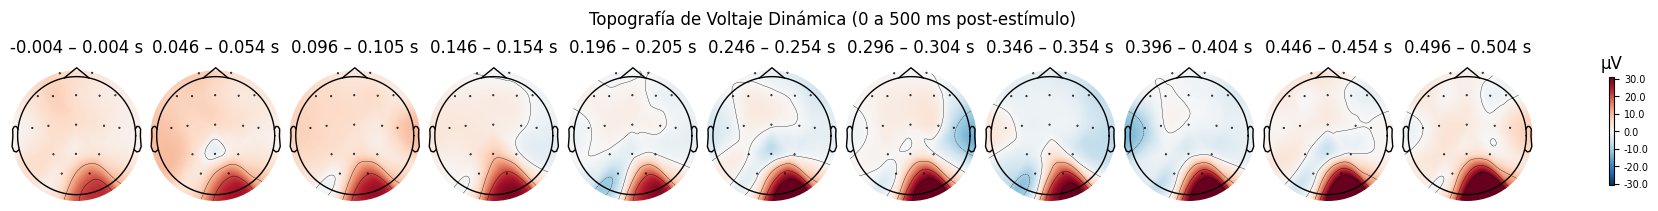

In [62]:
# Topografía Dinámica a lo Largo del Tiempo

# Tiempos específicos que vamos a visualizar en segundos
topo_times = np.arange(0.0, 0.51, 0.05)


fig_dynamic = grand_average_erp.plot_topomap(
    times=topo_times,
    ch_type='eeg',
    average=0.01,
    show=False
)


fig_dynamic.suptitle('Topografía de Voltaje Dinámica (0 a 500 ms post-estímulo)')
plt.savefig('Topomaps_Dinamicos.png')

Generando Gráfico de Mariposa y GFP...


C:\Users\rayom\AppData\Local\Temp\ipykernel_14972\3733944650.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_butterfly.tight_layout(rect=[0, 0.03, 1, 0.95])


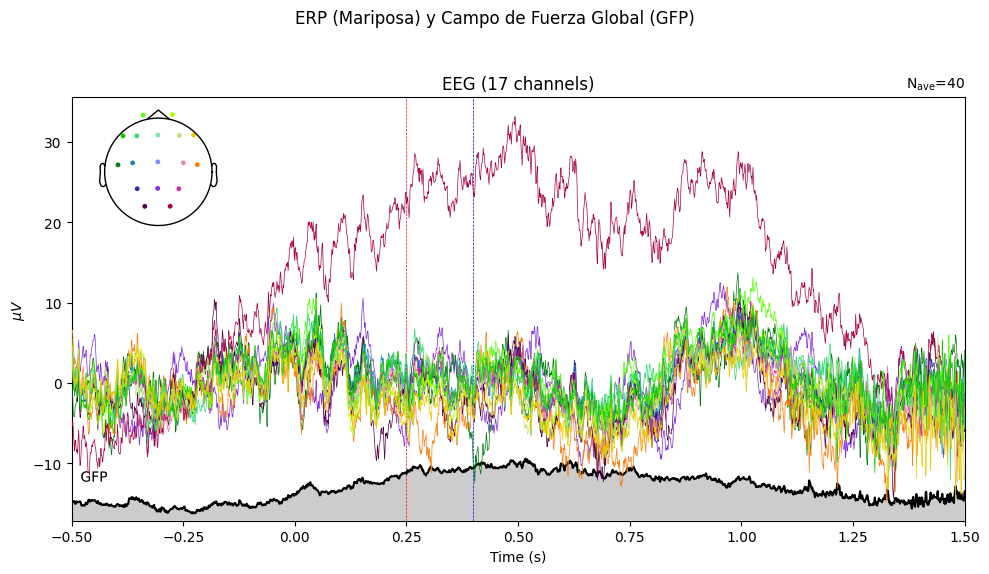

In [95]:
# 4.7. Gráfico de Mariposa y GFP ???????????????????????????????????????
print("Generando Gráfico de Mariposa y GFP...")

fig_butterfly = plt.figure(figsize=(10, 6))

grand_average_erp.plot(
    axes=fig_butterfly.add_subplot(111),
    spatial_colors=True,
    gfp=True,
    units=r"$\mu V$",
    time_unit='s',
    show=False,
)

fig_butterfly.suptitle('ERP (Mariposa) y Campo de Fuerza Global (GFP)')

ax_butterfly = fig_butterfly.axes[0]
ax_butterfly.axvline(n2_time, color='r', linestyle='--', linewidth=0.5)
ax_butterfly.axvline(p2_time, color='b', linestyle='--', linewidth=0.5)


fig_butterfly.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('Butterfly_and_GFP.png')